In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import ndimage
import pandas as pd

from tensorflow.keras import models, layers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU

import os

In [2]:
base_dir='../data/chest_xray/'

train_path = '../data/chest_xray/train'

validation_path = '../data/chest_xray/val'

test_path = '../data/chest_xray/test'

full_train_path = '../data/chest_xray/full_train'

In [3]:
train_pneumonia=os.listdir('../data/chest_xray/train/PNEUMONIA/')
train_normal=os.listdir('../data/chest_xray/train/NORMAL/')
val_dir_normal=os.listdir('../data/chest_xray/val/NORMAL/')
test_dir_normal=os.listdir('../data/chest_xray/test/NORMAL/')
val_dir_pneumonia=os.listdir('../data/chest_xray/val/PNEUMONIA/')
test_dir_pneumonia=os.listdir('../data/chest_xray/test/PNEUMONIA/')


##trying out combining training and validation sets and using a validation ratio when fitting models
full_train_pneumonia = os.listdir('../data/chest_xray/full_train/PNEUMONIA')
full_train_normal = os.listdir('../data/chest_xray/full_train/NORMAL')


##list object containing 'NORMAL' & 'PNEUMONIA'
label_string = os.listdir('../data/chest_xray/train')

In [4]:
# Greyscale distribution histogram - done, Jamie
# Class distribution - heavily weighted towards positive class (pneumonia) - done, Jamie
# Address class imbalance - incorporate flipped 0-class images - Rachel wrote a function for this
# Mean values for negative and positive classes - Svitlana 
# Look for outliers
# Look at subracting the pixel mean
# Apply matrix transformations to further define images - 
# Data Augmentation - Svitlana will make an attempt

In [5]:
print("Train set w/ pneumonia: ", len(train_pneumonia))
print("Train set normal: ", len(train_normal))
print("Validation set w/ pneumonia: ", len(val_dir_pneumonia))
print("Validation set normal: ", len(val_dir_normal))
print("Test set w/ pneumonia: ", len(test_dir_pneumonia))
print("Test set normal: ", len(test_dir_normal))
print("Full training set w/pneumonia (combined w/validation): ", len(full_train_pneumonia))
print("Full training set normal (combined w/validation): ", len(full_train_normal))

Train set w/ pneumonia:  2144
Train set normal:  699
Validation set w/ pneumonia:  1739
Validation set normal:  650
Test set w/ pneumonia:  390
Test set normal:  234
Full training set w/pneumonia (combined w/validation):  3883
Full training set normal (combined w/validation):  1349


In [6]:
2144+699, 1739+650, 390+234, 3883+1349

(2843, 2389, 624, 5232)

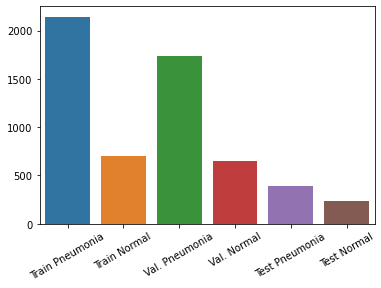

In [7]:
labels = ['Train Pneumonia', 'Train Normal', 'Val. Pneumonia', 'Val. Normal', 'Test Pneumonia', 'Test Normal']
dist = sns.barplot(x=labels, 
           y=[len(train_pneumonia), len(train_normal), len(val_dir_pneumonia), len(val_dir_normal), len(test_dir_pneumonia), len(test_dir_normal)],)

dist.set_xticklabels(labels = labels, rotation = 30);

In [8]:
#loading images for training set - pneumonia

plt.suptitle("Patients with Pneumonia")
for i in range(0,4):
    img = train_pneumonia[i]
    img = load_img(train_path+'/PNEUMONIA/'+img)
#   plt.imshow(img)
#   plt.show()

<Figure size 432x288 with 0 Axes>

In [9]:
#loading images for training set - normal

plt.suptitle("Normal Patients")
for i in range(0,4):
    img = train_normal[i]
    img = load_img(train_path+'/NORMAL/'+img)
#    plt.imshow(img)
#    plt.show()

<Figure size 432x288 with 0 Axes>

In [10]:
train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=2843,
                                                 color_mode = 'grayscale',                
                                                 class_mode='binary')

val_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(validation_path,
                                            target_size=(224, 224),
                                            shuffle=True,
                                            batch_size=2389,
                                            color_mode = 'grayscale',                      
                                            class_mode='binary')

test_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=624,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

##Image generator object for full training folder
full_train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(full_train_path,
                                            target_size=(224, 224),
                                            batch_size=5232,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

Found 2843 images belonging to 2 classes.
Found 2389 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [11]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(val_gen)
test_images, test_labels = next(test_gen)

##full training folder
full_train_images, full_train_labels = next(full_train_gen)

In [12]:
print("Train image shape:", train_images.shape, "train label shape:", train_labels.shape)
print("Val image shape:", val_images.shape, "val label shape:", val_labels.shape)
print("Test image shape:", test_images.shape, "test label shape:", test_labels.shape)

print("Full Train image shape:", full_train_images.shape, "full train label shape:", full_train_labels.shape)

Train image shape: (2843, 224, 224, 1) train label shape: (2843,)
Val image shape: (2389, 224, 224, 1) val label shape: (2389,)
Test image shape: (624, 224, 224, 1) test label shape: (624,)
Full Train image shape: (5232, 224, 224, 1) full train label shape: (5232,)


In [13]:
train_x = train_images.reshape(train_images.shape[0], -1)
val_x = val_images.reshape(val_images.shape[0], -1)
test_x = test_images.reshape(test_images.shape[0], -1)

full_train_x = full_train_images.reshape(full_train_images.shape[0], -1)

In [14]:
train_x.shape, val_x.shape, test_x.shape, full_train_x.shape

((2843, 50176), (2389, 50176), (624, 50176), (5232, 50176))

In [15]:
train_y = np.reshape(train_labels[:], (2843,1))
val_y = np.reshape(val_labels[:], (2389,1))
test_y = np.reshape(test_labels[:], (624,1))

##full training set labels
full_train_y = np.reshape(full_train_labels[:], (5232,1))

In [16]:
train_y.shape, val_y.shape, test_y.shape, full_train_y.shape

((2843, 1), (2389, 1), (624, 1), (5232, 1))

# FSM  
### using one hidden layer

In [17]:
np.random.seed(42)


model = models.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(50176,)))
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics= (['accuracy'], metrics.Recall()))

history = model.fit(train_x,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_x, val_y))

Epoch 1/25
89/89 [==============================] - 1s 14ms/step - loss: 0.5412 - accuracy: 0.7566 - recall: 0.9604 - val_loss: 0.3993 - val_accuracy: 0.8037 - val_recall: 0.9960
Epoch 2/25
89/89 [==============================] - 1s 12ms/step - loss: 0.3608 - accuracy: 0.8466 - recall: 0.9599 - val_loss: 0.2992 - val_accuracy: 0.8635 - val_recall: 0.9793
Epoch 3/25
89/89 [==============================] - 1s 12ms/step - loss: 0.2954 - accuracy: 0.8836 - recall: 0.9627 - val_loss: 0.2448 - val_accuracy: 0.8974 - val_recall: 0.9724
Epoch 4/25
89/89 [==============================] - 1s 12ms/step - loss: 0.2495 - accuracy: 0.9029 - recall: 0.9613 - val_loss: 0.2781 - val_accuracy: 0.8535 - val_recall: 0.9942
Epoch 5/25
89/89 [==============================] - 1s 12ms/step - loss: 0.2251 - accuracy: 0.9152 - recall: 0.9678 - val_loss: 0.2199 - val_accuracy: 0.9058 - val_recall: 0.9868
Epoch 6/25
89/89 [==============================] - 1s 12ms/step - loss: 0.2184 - accuracy: 0.9170 - reca

# First CNN 

In [19]:
batch_size = 64
epochs = 10
num_classes = 2

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 , 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [21]:
model.compile(optimizer = 'rmsprop', 
              loss = 'binary_crossentropy', 
              metrics = (['accuracy'], metrics.Recall()))

In [22]:
history = model.fit(train_images, train_y, epochs = epochs, batch_size = batch_size, validation_data=(val_images, val_y))

Epoch 1/10
45/45 [==============================] - 88s 2s/step - loss: 0.8752 - accuracy: 0.7703 - recall_2: 0.9104 - val_loss: 0.3453 - val_accuracy: 0.8560 - val_recall_2: 0.9212
Epoch 2/10
45/45 [==============================] - 88s 2s/step - loss: 0.3746 - accuracy: 0.9128 - recall_2: 0.9520 - val_loss: 0.2904 - val_accuracy: 0.8794 - val_recall_2: 0.9747
Epoch 3/10
45/45 [==============================] - 88s 2s/step - loss: 0.1885 - accuracy: 0.9339 - recall_2: 0.9604 - val_loss: 0.2995 - val_accuracy: 0.8841 - val_recall_2: 0.8683
Epoch 4/10
45/45 [==============================] - 86s 2s/step - loss: 0.1464 - accuracy: 0.9444 - recall_2: 0.9627 - val_loss: 0.2404 - val_accuracy: 0.9062 - val_recall_2: 0.9908
Epoch 5/10
45/45 [==============================] - 87s 2s/step - loss: 0.1085 - accuracy: 0.9581 - recall_2: 0.9743 - val_loss: 1.4231 - val_accuracy: 0.7359 - val_recall_2: 1.0000
Epoch 6/10
45/45 [==============================] - 86s 2s/step - loss: 0.1117 - accuracy:

In [23]:
results_train = model.evaluate(train_images, train_y)

89/89 [==============================] - 18s 202ms/step - loss: 0.0222 - accuracy: 0.9923 - recall_2: 0.9944


In [24]:
history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x24f3cbb0c10>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.8752040266990662,
   0.37461546063423157,
   0.188506618142128,
   0.14644724130630493,
   0.10848119109869003,
   0.11169004440307617,
   0.07999250292778015,
   0.0740526020526886,
   0.053233128041028976,
   0.04533915966749191],
  'accuracy': [0.770313024520874,
   0.9127681851387024,
   0.933872640132904,
   0.9444249272346497,
   0.9581428170204163,
   0.9634189009666443,
   0.9711572527885437,
   0.9760816097259521,
   0.9795989990234375,
   0.9855785965919495],
  'recall_2': [0.9104477763175964,
   0.951958954334259,
   0.9603545069694519,
   0.9626865386962891,
   0.9743469953536987,
   0.9780783653259277,
   0.9790111780166626,
   0.9850746393203735,
   0.9864738583564758,
   0.9902052283287048],
  'val_loss': [0.34527409076690674,
   0.29040345549583435,
   0.29949530959129333,
   0.2403

In [25]:
model_epochs = history.epoch
model_recall_train = history.history['recall_2']
model_recall_val = history.history['val_recall_2']
model_accuracy_train = history.history['accuracy']
model_accuracy_val = history.history['val_accuracy']

## Plotting Accuracy and Recall Against Epochs

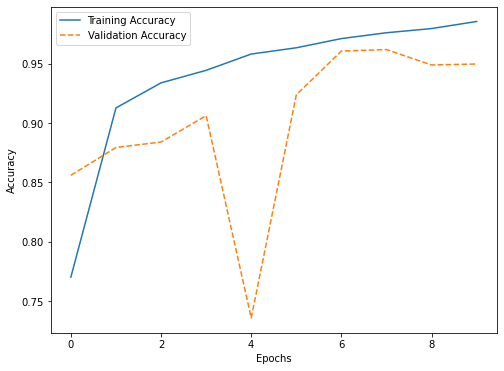

In [26]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs, model_accuracy_train, label = 'Training Accuracy')
ax.plot(model_epochs, model_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

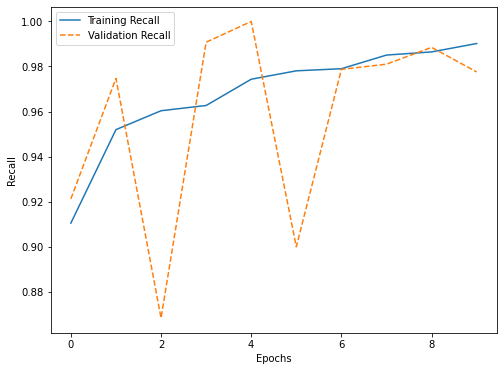

In [27]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs, model_recall_train, label = 'Training Recall')
ax.plot(model_epochs, model_recall_val, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

## Second CNN

In [28]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(224 , 224, 1)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model2.add(LeakyReLU())
model2.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [29]:
history2 = model2.fit(train_images, train_y, epochs = epochs, batch_size = batch_size, validation_data=(val_images, val_y))

Epoch 1/10
45/45 [==============================] - 95s 2s/step - loss: 0.5359 - accuracy: 0.7629 - recall_3: 0.8680 - val_loss: 0.4462 - val_accuracy: 0.8003 - val_recall_3: 0.9833
Epoch 2/10
45/45 [==============================] - 99s 2s/step - loss: 0.2664 - accuracy: 0.9019 - recall_3: 0.9398 - val_loss: 0.2573 - val_accuracy: 0.8966 - val_recall_3: 0.9758
Epoch 3/10
45/45 [==============================] - 94s 2s/step - loss: 0.2242 - accuracy: 0.9209 - recall_3: 0.9501 - val_loss: 0.2000 - val_accuracy: 0.9238 - val_recall_3: 0.9241
Epoch 4/10
45/45 [==============================] - 95s 2s/step - loss: 0.1924 - accuracy: 0.9367 - recall_3: 0.9590 - val_loss: 0.2027 - val_accuracy: 0.9217 - val_recall_3: 0.9914
Epoch 5/10
45/45 [==============================] - 95s 2s/step - loss: 0.2329 - accuracy: 0.9413 - recall_3: 0.9599 - val_loss: 0.1485 - val_accuracy: 0.9452 - val_recall_3: 0.9850
Epoch 6/10
45/45 [==============================] - 99s 2s/step - loss: 0.1415 - accuracy:

In [30]:
results_train2 = model2.evaluate(train_images, train_y)

89/89 [==============================] - 19s 213ms/step - loss: 0.0789 - accuracy: 0.9687 - recall_3: 0.9590


## Third CNN

In [31]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (8, 8), activation='relu',
                        input_shape=(224 , 224, 1)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model3.add(LeakyReLU())
model3.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model3.add(Dropout(.5))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [32]:
history3 = model3.fit(train_images, train_y, epochs = epochs, batch_size = batch_size, validation_data=(val_images, val_y))

Epoch 1/10
45/45 [==============================] - 114s 3s/step - loss: 0.6768 - accuracy: 0.7742 - recall_4: 0.9118 - val_loss: 0.4852 - val_accuracy: 0.7622 - val_recall_4: 0.9896
Epoch 2/10
45/45 [==============================] - 110s 2s/step - loss: 0.3521 - accuracy: 0.8590 - recall_4: 0.9146 - val_loss: 0.3431 - val_accuracy: 0.8640 - val_recall_4: 0.9816
Epoch 3/10
45/45 [==============================] - 111s 2s/step - loss: 0.2193 - accuracy: 0.9159 - recall_4: 0.9515 - val_loss: 0.2442 - val_accuracy: 0.9062 - val_recall_4: 0.9505
Epoch 4/10
45/45 [==============================] - 110s 2s/step - loss: 0.2577 - accuracy: 0.9114 - recall_4: 0.9431 - val_loss: 1.2545 - val_accuracy: 0.7321 - val_recall_4: 1.0000
Epoch 5/10
45/45 [==============================] - 112s 2s/step - loss: 0.1796 - accuracy: 0.9384 - recall_4: 0.9660 - val_loss: 0.2278 - val_accuracy: 0.9138 - val_recall_4: 0.9557
Epoch 6/10
45/45 [==============================] - 111s 2s/step - loss: 0.1656 - acc

In [33]:
results_train3 = model3.evaluate(train_images, train_y)

89/89 [==============================] - 21s 231ms/step - loss: 0.0538 - accuracy: 0.9785 - recall_4: 0.9771


In [34]:
#history3.__dict__

In [35]:
model_epochs3 = history3.epoch
model_recall_train3 = history3.history['recall_4']
model_recall_val3 = history3.history['val_recall_4']
model_accuracy_train3 = history3.history['accuracy']
model_accuracy_val3 = history3.history['val_accuracy']

## Plotting CNN3

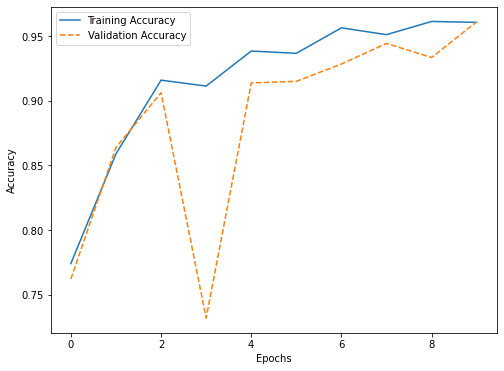

In [36]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs3, model_accuracy_train3, label = 'Training Accuracy')
ax.plot(model_epochs3, model_accuracy_val3, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

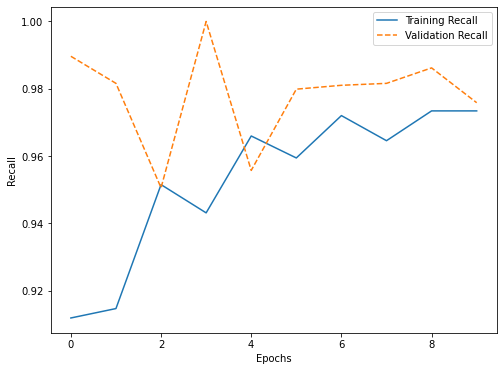

In [37]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs3, model_recall_train3, label = 'Training Recall')
ax.plot(model_epochs3, model_recall_val3, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

## Fitting CNN3 on full training set with a validation percentage

In [38]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (8, 8), activation='relu',
                        input_shape=(224 , 224, 1)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model4.add(LeakyReLU())
model4.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model4.add(Dropout(.5))
model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [39]:
history4 = model4.fit(full_train_images, full_train_y, epochs = 15, batch_size = batch_size, validation_split=.25)

Epoch 1/15
62/62 [==============================] - 142s 2s/step - loss: 0.5796 - accuracy: 0.7582 - recall_5: 0.8827 - val_loss: 0.3532 - val_accuracy: 0.8333 - val_recall_5: 0.9990
Epoch 2/15
62/62 [==============================] - 147s 2s/step - loss: 0.3837 - accuracy: 0.8688 - recall_5: 0.9129 - val_loss: 0.3054 - val_accuracy: 0.9044 - val_recall_5: 0.9090
Epoch 3/15
62/62 [==============================] - 146s 2s/step - loss: 0.3228 - accuracy: 0.9218 - recall_5: 0.9551 - val_loss: 0.1073 - val_accuracy: 0.9602 - val_recall_5: 0.9731
Epoch 4/15
62/62 [==============================] - 148s 2s/step - loss: 0.2124 - accuracy: 0.9276 - recall_5: 0.9568 - val_loss: 0.1192 - val_accuracy: 0.9625 - val_recall_5: 0.9772
Epoch 5/15
62/62 [==============================] - 146s 2s/step - loss: 0.1656 - accuracy: 0.9452 - recall_5: 0.9660 - val_loss: 0.2943 - val_accuracy: 0.8731 - val_recall_5: 0.8294
Epoch 6/15
62/62 [==============================] - 140s 2s/step - loss: 0.3132 - acc

In [40]:
history3.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x24f40c4ed00>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.5796013474464417,
   0.38365522027015686,
   0.32276445627212524,
   0.21237385272979736,
   0.1655960977077484,
   0.31321632862091064,
   0.113788902759552,
   0.14431077241897583,
   0.12017685174942017,
   0.1246732547879219,
   0.09951247274875641,
   0.0855959877371788,
   0.08045664429664612,
   0.28758499026298523,
   0.07965467870235443],
  'accuracy': [0.7581549286842346,
   0.8687563538551331,
   0.9217634797096252,
   0.9276248812675476,
   0.9452089667320251,
   0.947757363319397,
   0.9602446556091309,
   0.9495412707328796,
   0.9582059383392334,
   0.9582059383392334,
   0.9655963182449341,
   0.9706931710243225,
   0.9724770784378052,
   0.9701834917068481,
   0.9683995842933655],
  'recall_5': [0.8827160596847534,
   0.9128943681716919,
   0.9550754427909851,
   0.9567901492118835

In [41]:
model_epochs4 = history4.epoch
model_recall_train4 = history4.history['recall_5']
model_recall_val4 = history4.history['val_recall_5']
model_accuracy_train4 = history4.history['accuracy']
model_accuracy_val4 = history4.history['val_accuracy']
model_loss_train4 = history4.history['loss']
model_loss_val4 = history4.history['val_loss']

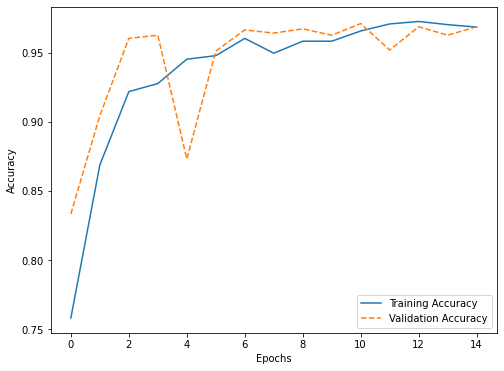

In [42]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs4, model_accuracy_train4, label = 'Training Accuracy')
ax.plot(model_epochs4, model_accuracy_val4, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

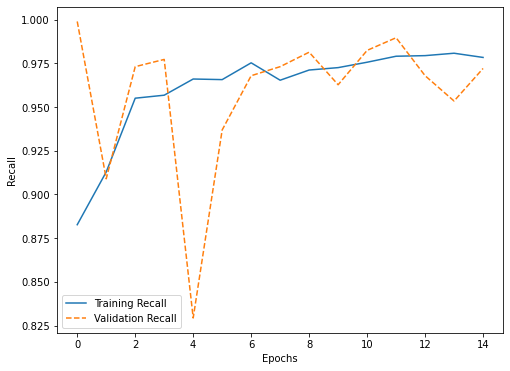

In [43]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs4, model_recall_train4, label = 'Training Recall')
ax.plot(model_epochs4, model_recall_val4, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

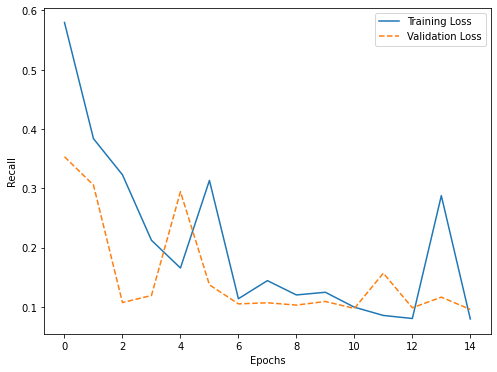

In [44]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs4, model_loss_train4, label = 'Training Loss')
ax.plot(model_epochs4, model_loss_val4, linestyle = '--', label = 'Validation Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

In [45]:
full_results = model4.evaluate(full_train_images, full_train_y)

164/164 [==============================] - 40s 245ms/step - loss: 0.0639 - accuracy: 0.9763 - recall_5: 0.9753


In [46]:
y_train_preds = model4.predict_generator(full_train_images)
y_train_pred = np.round(y_train_preds).astype(int)

Instructions for updating:
Please use Model.predict, which supports generators.


In [47]:
y_true = full_train_y.astype(int)

In [48]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

confusion_matrix(y_true, y_train_pred)

array([[1321,   28],
       [  96, 3787]], dtype=int64)

## CNN 4 - further fiddling - tanh activation

There was a marked decrease in loss as the number of epochs was increased. We began with 10, saw success with 15, and increased to 20.

In [63]:
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (4, 4), activation='tanh',
                        input_shape=(224 , 224, 1)))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Conv2D(32, (4, 4), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model5.add(LeakyReLU())
model5.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model5.add(Dropout(.5))
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [64]:
history5 = model5.fit(full_train_images, full_train_y, epochs = 20, batch_size = batch_size, validation_split=.25)

Epoch 1/20
62/62 [==============================] - 113s 2s/step - loss: 0.6105 - accuracy: 0.7523 - recall_7: 0.9877 - val_loss: 0.3234 - val_accuracy: 0.9060 - val_recall_7: 0.9421
Epoch 2/20
62/62 [==============================] - 129s 2s/step - loss: 0.3045 - accuracy: 0.8761 - recall_7: 0.9578 - val_loss: 0.2429 - val_accuracy: 0.9235 - val_recall_7: 0.9380
Epoch 3/20
62/62 [==============================] - 136s 2s/step - loss: 0.2052 - accuracy: 0.9365 - recall_7: 0.9554 - val_loss: 0.0993 - val_accuracy: 0.9641 - val_recall_7: 0.9876
Epoch 4/20
62/62 [==============================] - 133s 2s/step - loss: 0.1458 - accuracy: 0.9434 - recall_7: 0.9640 - val_loss: 0.1345 - val_accuracy: 0.9602 - val_recall_7: 0.9514
Epoch 5/20
62/62 [==============================] - 134s 2s/step - loss: 0.1099 - accuracy: 0.9587 - recall_7: 0.9719 - val_loss: 0.1269 - val_accuracy: 0.9557 - val_recall_7: 0.9431
Epoch 6/20
62/62 [==============================] - 135s 2s/step - loss: 0.1167 - acc

In [65]:
full_results5 = model5.evaluate(full_train_images, full_train_y)

164/164 [==============================] - 31s 188ms/step - loss: 0.0266 - accuracy: 0.9941 - recall_7: 0.9948


In [66]:
y_preds = model5.predict_generator(full_train_images)
y_pred = np.round(y_preds)

In [67]:
y_pred = y_pred.astype(int)
y_true = full_train_y.astype(int)

In [68]:
confusion_matrix(y_true, y_pred)

array([[1338,   11],
       [  20, 3863]], dtype=int64)

In [69]:
history5.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x24f4365f100>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6105262637138367,
   0.3045423924922943,
   0.20515096187591553,
   0.14584898948669434,
   0.10989250242710114,
   0.11669862270355225,
   0.08918923884630203,
   0.08967211097478867,
   0.06821960210800171,
   0.06573937833309174,
   0.05316847190260887,
   0.04826115444302559,
   0.04003699868917465,
   0.04077310487627983,
   0.03660350665450096,
   0.02713562361896038,
   0.032160986214876175,
   0.02622319757938385,
   0.017180006951093674,
   0.016931304708123207],
  'accuracy': [0.752293586730957,
   0.8761467933654785,
   0.9365443587303162,
   0.9434250593185425,
   0.9587156176567078,
   0.9574413895606995,
   0.9658511877059937,
   0.9671253561973572,
   0.9757900238037109,
   0.9737512469291687,
   0.9806320071220398,
   0.9811416864395142,
   0.9834352731704712,
   0.9862385392189026,

In [71]:
model_epochs5 = history5.epoch
model_recall_train5 = history5.history['recall_7']
model_recall_val5 = history5.history['val_recall_7']
model_accuracy_train5 = history5.history['accuracy']
model_accuracy_val5 = history5.history['val_accuracy']
model_loss_train5 = history5.history['loss']
model_loss_val5 = history5.history['val_loss']

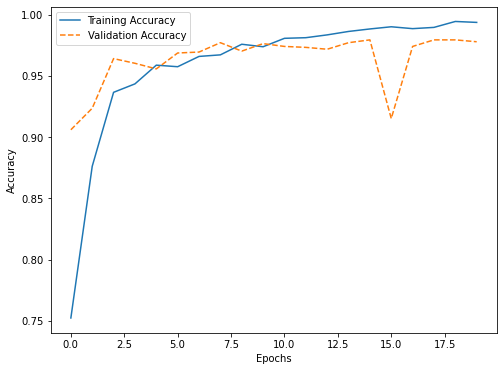

In [72]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs5, model_accuracy_train5, label = 'Training Accuracy')
ax.plot(model_epochs5, model_accuracy_val5, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

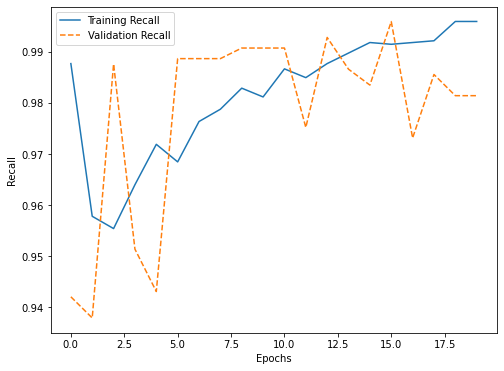

In [73]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs5, model_recall_train5, label = 'Training Recall')
ax.plot(model_epochs5, model_recall_val5, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

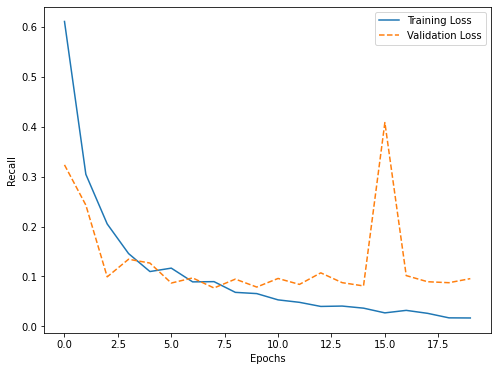

In [75]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs4, model_loss_train5, label = 'Training Loss')
ax.plot(model_epochs4, model_loss_val5, linestyle = '--', label = 'Validation Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

In [76]:
test_results = model4.evaluate(test_images, test_y)

20/20 [==============================] - 3s 152ms/step - loss: 2.0647 - accuracy: 0.7692 - recall_6: 0.9821 1s - loss: 1.8666 - accuracy: 0.7585 - recall


In [77]:
test_results

[2.064664602279663, 0.7692307829856873, 0.9820512533187866]

In [79]:
y_test_preds = model5.predict_generator(test_images)
y_test_pred = np.round(y_test_preds).astype(int)

In [80]:
y_test_true = test_y.astype(int)

In [81]:
confusion_matrix(y_test_true, y_test_pred)

array([[ 82, 152],
       [  4, 386]], dtype=int64)